In [186]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.base import clone
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [187]:
#Importing csv data
states_data = pd.read_csv('4.18states.csv')
counties = pd.read_csv('abridged_couties.csv')
confirmed = pd.read_csv('time_series_covid19_confirmed_US.csv')
deaths = pd.read_csv('time_series_covid19_deaths_US.csv')

In [250]:
#Cleaning Data to answer the following questions
#We will first create tables only where California is concerned
ca_data = states_data[states_data["Province_State"] == 'California']
ca_counties = counties[counties["State"] == 'California'][["countyFIPS", 'PopulationEstimate2018', "PopulationDensityperSqMile2010", "MedicareEnrollment,AgedTot2017", "SVIPercentile"]]

#Percentiles should not be negative
ca_counties = ca_counties[ca_counties["SVIPercentile"] > 0]
ca_deaths = deaths[deaths["Province_State"] == 'California']

#We only care about the total deaths, which is found in column 4/18/20
ca_deaths = ca_deaths[["FIPS", "4/18/20"]]
ca_deaths.columns = ["FIPS", "deaths"]

confirmed_ca = confirmed[confirmed["Province_State"] == "California"]
#We only care about total confirmed cases, which is also the column 4/18/20
confirmed_ca = confirmed_ca[["FIPS", "4/18/20"]]
confirmed_ca.columns = ["FIPS", "confirmed"]

#convert String FIPS to float so we can use it in conjunction with other tables
ca_counties["countyFIPS"] = ca_counties["countyFIPS"].apply(lambda x: float(x))
#Join deaths and confirmed columns into counties table using FIPS. Remove counties without sufficient death data.
ca_counties = ca_counties.join(other = ca_deaths, lsuffix = "countyFIPS", rsuffix = "FIPS")
ca_counties = ca_counties.join(other = confirmed_ca, lsuffix = "countyFIPS", rsuffix = "FIPS")
ca_counties = ca_counties.fillna(-1)
ca_counties = ca_counties[ca_counties["deaths"] > 0]
ca_counties = ca_counties[ca_counties["confirmed"] > 0]
ca_counties = ca_counties.drop(["FIPSFIPS", "FIPScountyFIPS"], axis = 1)
ca_counties = ca_counties[ca_counties["deaths"] + ca_counties["confirmed"] != 0]
ca_counties["confirm_perc"] = ca_counties["confirmed"]/ca_counties["PopulationEstimate2018"]

Text(0.5, 1.0, 'SVIPercentile vs confirmed cases')

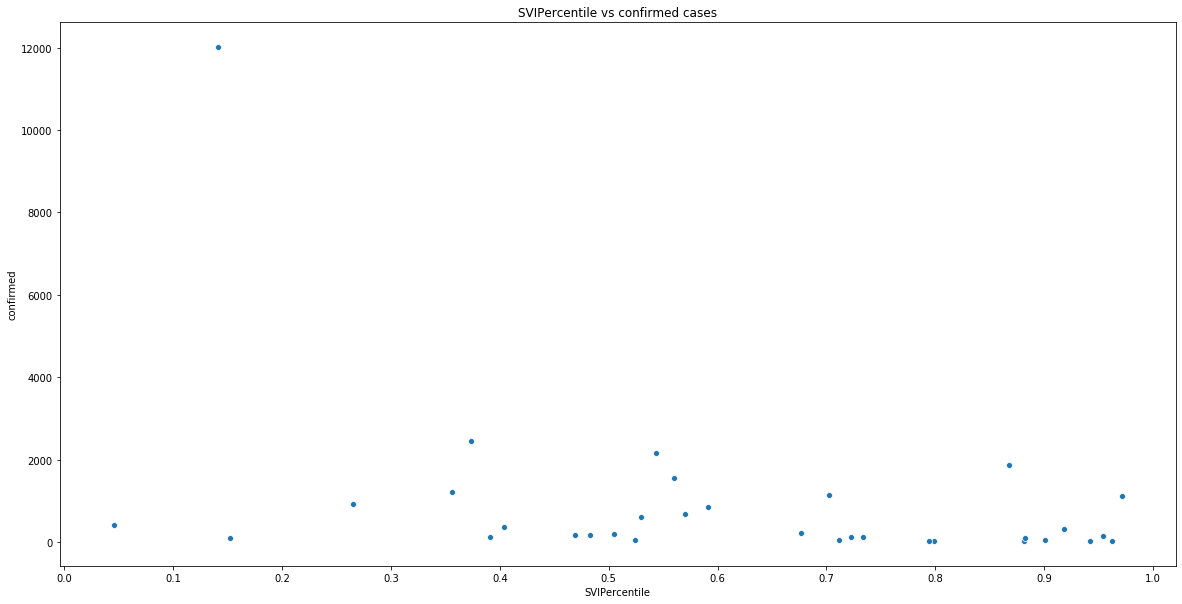

In [209]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(ca_counties["SVIPercentile"], ca_counties["confirmed"])
ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.title("SVIPercentile vs confirmed cases")

In [190]:
#We conduct Train Test Split here, train data is 0.8 of our original and test data is 0.2
tr, te = train_test_split(ca_counties, test_size=0.2)

In [198]:
#Our training features don't require the IDs, the death count, or the confirmed count.
#Our used features are 2018 Population, Population Density, Medicare Enrollment, SVI Percentile (an indicator of at risk cities)
x_tr = tr.drop(['countyFIPS', 'deaths', 'confirmed', "confirm_perc"], axis = 1)
y_tr = tr["confirm_perc"]
x_te = te.drop(['countyFIPS', 'deaths', 'confirmed', "confirm_perc"], axis = 1)
y_te = te["confirm_perc"]

#Using Logistic Regression, we predict the number of confirmed cases 
model = LinearRegression()
model.fit(x_tr, y_tr)
y_pred = model.predict(x_te)

#Function that computes RMSE
def computeRMSE(y, y_hat):
    return np.sqrt(1/(len(y)) * np.sum((y - y_hat) * (y - y_hat)))

#Function that computes cross_validation
def cross_validate_rmse(model, tr_x, tr_y, n):
    model = clone(model)
    n_fold = KFold(n_splits=n)
    rmse_values = []
    for tr_ind, va_ind in n_fold.split(tr_x):
        model.fit(tr_x.iloc[tr_ind,:], tr_y.iloc[tr_ind])
        rmse_values.append(computeRMSE(tr_y.iloc[va_ind], model.predict(tr_x.iloc[va_ind,:])))
    return np.mean(rmse_values)

print(computeMSE(y_te, y_pred))
print(cross_validate_rmse(model, x_tr, y_tr, 5))


986205.3
1458.6277676541308


Initially, we wished to train on the California data because we wanted to predict if different confirmed cases in Californian counties. However, because many Californian counties didn't actually report their number of cases, we lost a lot of data. Having too little training data has negatively impacted our performance, as can be seen by computing MSE. Next, we will attempt to use the entirety of the US as training data.

In [247]:
#This follows the same process as the first few cells. We only take the features we want and rename the date column to something more meaningful.
clean_counties = counties[["countyFIPS", 'PopulationEstimate2018', "PopulationDensityperSqMile2010", "MedicareEnrollment,AgedTot2017", "SVIPercentile"]]
clean_counties = clean_counties[clean_counties["SVIPercentile"] > 0]
clean_counties = clean_counties[clean_counties["PopulationEstimate2018"] > 0]
clean_counties = clean_counties[clean_counties["MedicareEnrollment,AgedTot2017"] > 0]

clean_deaths = deaths[["FIPS", "4/18/20"]]
clean_deaths.columns = ["FIPS", "deaths"]
clean_deaths["deaths"] = clean_deaths["deaths"]
clean_confirm = confirmed[["FIPS", "4/18/20"]]
clean_confirm.columns = ["FIPS", "confirmed"]


#Hardcoding the removal of two 0-data rows, labeled City 1 and City 2
clean_counties = clean_counties[clean_counties["countyFIPS"] != 'City1']
clean_counties = clean_counties[clean_counties["countyFIPS"] != 'City2']
clean_counties["countyFIPS"] = clean_counties["countyFIPS"].apply(lambda x: float(x))

#Join deaths and confirmed columns into counties table using FIPS. Remove counties without sufficient death data.
clean_counties = clean_counties.join(other = clean_deaths, lsuffix = "countyFIPS", rsuffix = "FIPS")
clean_counties = clean_counties.join(other = clean_confirm, lsuffix = "countyFIPS", rsuffix = "FIPS")
clean_counties = clean_counties.fillna(-1)
clean_counties = clean_counties[clean_counties["deaths"] >= 0]
clean_counties = clean_counties[clean_counties["confirmed"] >= 0]
clean_counties = clean_counties.drop(["FIPSFIPS", "FIPScountyFIPS"], axis = 1)
#We're going to do a remove rows where deaths and confirmed are 0, because they haven't been infected so are not good indicators.
clean_counties = clean_counties[clean_counties["deaths"] + clean_counties["confirmed"] != 0]
#We are going to change the confirm column into a percentage
clean_counties["confirm_perc"] = clean_counties["confirmed"]/clean_counties["PopulationEstimate2018"]

C:\Users\Frank\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


C:\Users\Frank\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Log SVIPercentile vs Logged Percentage of confirmed cases')

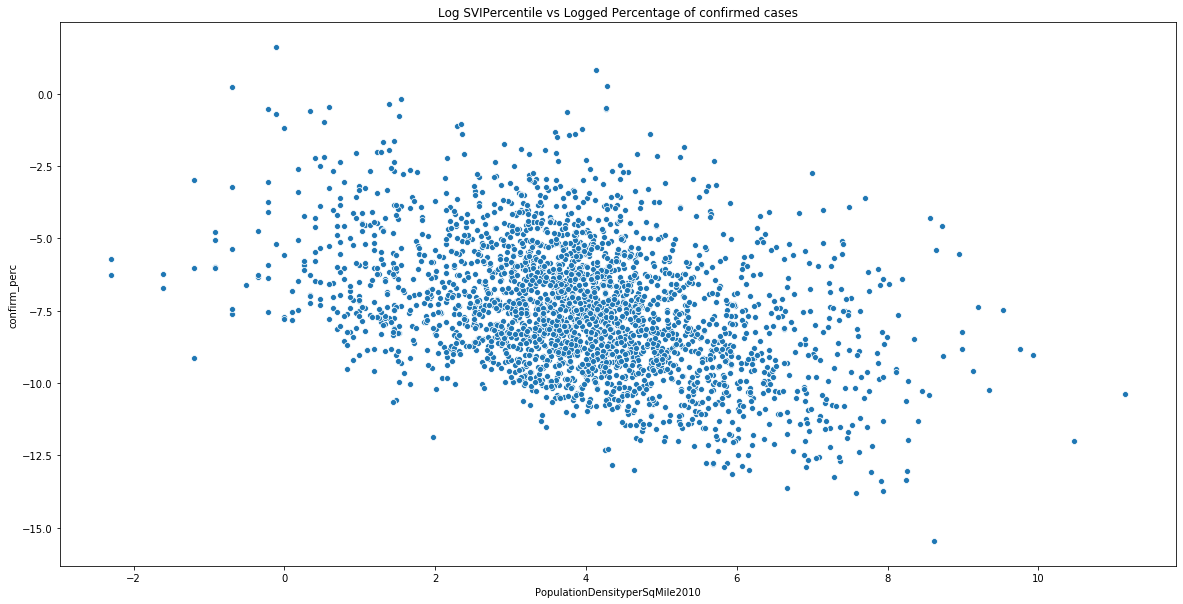

In [236]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(np.log(clean_counties["PopulationDensityperSqMile2010"]), np.log(clean_counties["confirm_perc"]))
plt.title("Log SVIPercentile vs Logged Percentage of confirmed cases")

In [261]:
#We conduct Train Test Split here, train data is 0.8 of our original and test data is 0.2
tr2, te2 = train_test_split(clean_counties, test_size=0.2)
x_tr2 = tr2.drop(['countyFIPS', 'deaths', 'confirmed', "confirm_perc"], axis = 1)
y_tr2 = tr2["confirm_perc"]
x_te2 = te2.drop(['countyFIPS', 'deaths', 'confirmed', "confirm_perc"], axis = 1)
y_te2 = te2["confirm_perc"]
#Using Logistic Regression, we predict the number of confirmed cases 
model2 = LinearRegression()
model2.fit(x_tr2, y_tr2)

print(cross_validate_rmse(model2, x_tr2, y_tr2, 5))

y_hat = model2.predict(x_te2)
computeRMSE(y_te2, y_hat)

0.10438999694924944


0.04847282456723436

We will now use PCA to find which of the four features are the "principal components," or the vectors with the most standard deviation.

In [253]:
copy = clean_counties.copy()
